In [4]:
# Importing Modules and libraries needed for AWS S3 storage, Deep Learning and Image Processing 
import os
import boto3
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import splitfolders
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras import layers
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50, DenseNet121, MobileNet, EfficientNetV2B0

from keras.layers import Dense, GlobalAveragePooling2D
from config import aws_access_key_id, aws_secret_access_key

ModuleNotFoundError: No module named 'config'

## Preprocessing

In [1]:
# paths
local_drug_directory = 'local_drug_directory'
train_dir = "output/train/"
valid_dir = "output/val/"

In [2]:
# define loading parameters
img_height = 224
img_width = 224
batch_size = 1

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# using ImageDataGenerator and flow_from_directory to preprocess the images
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_width,img_height),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode="categorical"
                                                   )

Found 437 images belonging to 23 classes.


In [7]:
# using ImageDataGenerator and flow_from_directory to preprocess the images
validation_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(img_width,img_height),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode="categorical"
                                                   )

Found 46 images belonging to 23 classes.


In [8]:
# to extract the class names for label
class_names = train_generator.class_indices.keys()
class_names

dict_keys(['Amoxicillin 500 mg', 'Apixaban 2.5 mg', 'Aprepitant 80 mg', 'Atomoxetine 25 mg', 'Calcitriol 0.00025', 'Prasugrel 10 MG', 'Ramipril 5 MG', 'Saxagliptin 5 MG', 'Sitagliptin 50 MG', 'Tadalafil 5 MG', 'carvedilol 3.125', 'celecoxib 200', 'duloxetine 30', 'eltrombopag 25', 'metformin_500', 'montelukast-10', 'mycophenolate-250', 'omeprazole_40', 'oseltamivir-45', 'pantaprazole-40', 'pitavastatin_1', 'prednisone_5', 'sertraline_25'])

In [9]:
sample_names = []
training_samples = []

[training_samples.append(list(train_generator.classes).count(x)) for x in range(0,23)]

# Get only drug name, not dosage
for x in list(class_names):
    drug = x.split()[0]
    
    if drug == x:
        drug = x.split(sep = '_')[0]
        
    if drug == x:
        drug = x.split(sep = '-')[0]
    
    sample_names.append(drug.capitalize())b


training_sample_size = pd.DataFrame({'Drug Name': sample_names,
                                    'count': training_samples})
training_sample_size

,Drug Name,count
0,Amoxicillin,19
1,Apixaban,19
2,Aprepitant,19
3,Atomoxetine,19
4,Calcitriol,19
5,Prasugrel,19
6,Ramipril,19
7,Saxagliptin,19
8,Sitagliptin,19
9,Tadalafil,19


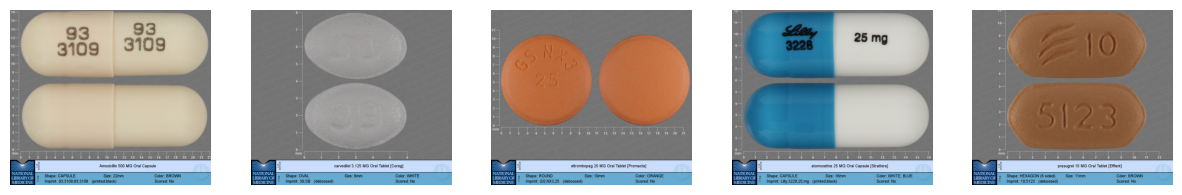

In [10]:
def show_sample_images(local_directory):
    # Go into the local directory and put all subdirectories in a List
    subdirectories = [d for d in os.listdir(local_directory) if os.path.isdir(os.path.join(local_directory, d))]

    # Check if there are any subdirectories
    if not subdirectories:
        print("No subdirectories found in the directory.")
        return

    # Collect all image files from all subdirectories
    all_image_files = []
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(local_directory, subdirectory)

        # List all image files in the subdirectory
        image_files = [f for f in os.listdir(subdirectory_path) if f.lower().endswith(('.jpg', '.jpeg'))]

        # Add the image files to the combined list
        all_image_files.extend(os.path.join(subdirectory_path, f) for f in image_files)

    # Shuffle the combined list of image files
    random.shuffle(all_image_files)

    # Set the number of random images to display
    num_images_to_display = 5

    # Create subplots to display images side by side
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))  # Adjust figsize as needed

    # Loop to select and display 5 random images
    for i in range(num_images_to_display):
        # Check if there are still image files available
        if not all_image_files:
            break

        # Pop a random image from the combined list
        random_image_file = all_image_files.pop()

        # Load and display the randomly selected image
        img = mpimg.imread(random_image_file)

        # Display the image in the subplot
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis labels

    # Show the subplots
    plt.show()

# Example usage
show_sample_images(local_drug_directory)

-------
## Using MobileNet to train our data
-------

In [11]:
# define a base model with non trainable params
base_model = MobileNet(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
base_model.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [12]:
# set up our model and layers
model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(23, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 23)                23575     
                                                                 
Total params: 3252439 (12.41 MB)
Trainable params: 23575 (92.09 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


In [13]:
# compile the model
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [14]:
# fit the model
model_fitted = model.fit(train_generator,
                         epochs=2,
                         validation_data = validation_generator)


Epoch 1/2
437/437 [==============================] - 20s 40ms/step - loss: 1.0308 - accuracy: 0.7780 - val_loss: 0.0813 - val_accuracy: 1.0000
Epoch 2/2
437/437 [==============================] - 17s 39ms/step - loss: 0.0558 - accuracy: 1.0000 - val_loss: 0.0248 - val_accuracy: 1.0000


In [17]:
# display training loss and training accuracy
model_loss, model_accuracy = model.evaluate(validation_generator, verbose=2)
print(f" loss : {model_loss}, accuray : {model_accuracy}")

46/46 - 2s - loss: 0.0248 - accuracy: 1.0000 - 2s/epoch - 35ms/step
 loss : 0.024817680940032005, accuray : 1.0


## Display Training and Validation Accuracy and Loss

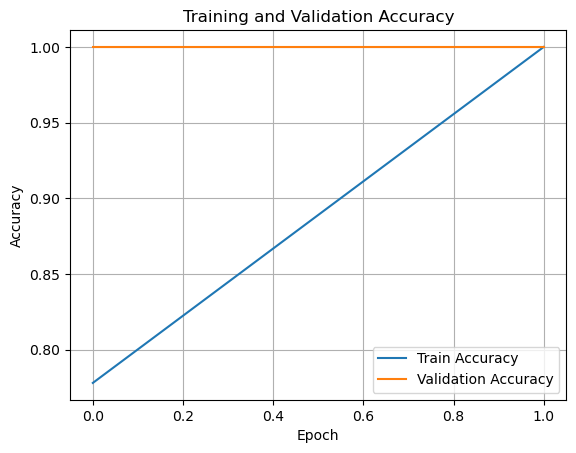

In [18]:
# Visualize the training and validation accuracy
plt.plot(model_fitted.history['accuracy'], label='Train Accuracy')
plt.plot(model_fitted.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Accuracy')

plt.show()

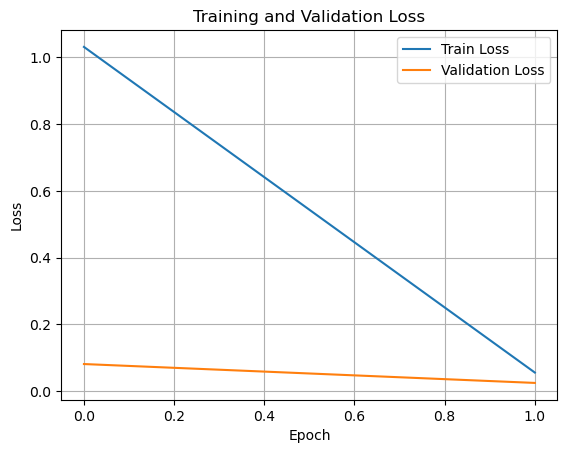

In [19]:
plt.plot(model_fitted.history['loss'], label='Train Loss')
plt.plot(model_fitted.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# save the model
# model.save('MobileNet_model.keras')